In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import functools
import jax
import jax.numpy as jp
import jax_flock as jf
import matplotlib.pyplot as plt
import stats

### Average Z

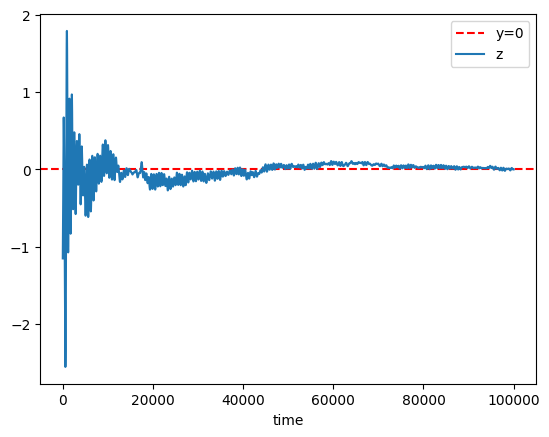

In [14]:
def average_z(state: jf.State) -> float:
    return jp.mean(state.position[:, 2])

params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

key = jax.random.PRNGKey(0)
state = jf.init_state(config, key)
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
zs = stats.time_average_with_history(state, next_state, 100000, average_z)

plt.axhline(y=0, color='r', linestyle='--', label=f'y=0')
plt.plot(zs, label='z')
plt.xlabel('time')
plt.legend()

### Average/std separation

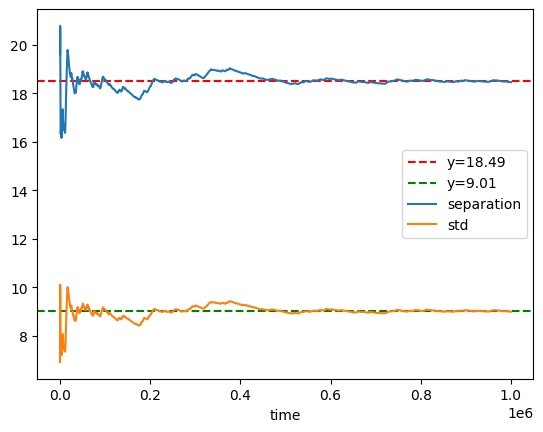

In [121]:
params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

key = jax.random.PRNGKey(0)
state = jf.init_state(config, key)
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
def J(state):
    dists = jf.pairwise_distances(state)
    # return jp.mean(dists)
    return jp.hstack([jp.mean(dists), jp.std(dists)])
    # print(jp.mean(dists).shape)
    # return jp.mean(dists, axis=0)
seps = stats.time_average_with_history(state, next_state, 1000000, J)
seps, stds = seps[:, 0], seps[:, 1]

plt.axhline(y=jp.mean(seps), color='r', linestyle='--', label=f'y={jp.mean(seps):.2f}')
plt.axhline(y=jp.mean(stds), color='g', linestyle='--', label=f'y={jp.mean(stds):.2f}')
plt.plot(seps, label='separation')
plt.plot(stds, label='std')
plt.xlabel('time')
plt.legend()

### Min sep

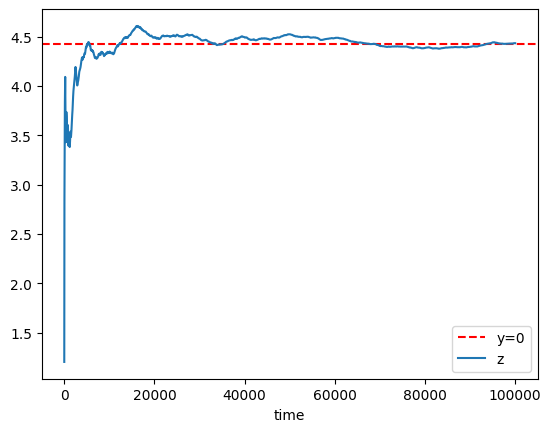

In [53]:
params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

key = jax.random.PRNGKey(0)
state = jf.init_state(config, key)
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
zs = stats.time_average_with_history(state, next_state, 100000, jf.min_sep)

plt.axhline(y=jp.mean(zs), color='r', linestyle='--', label=f'y=0')
plt.plot(zs, label='z')
plt.xlabel('time')
plt.legend()



### Escaped boids

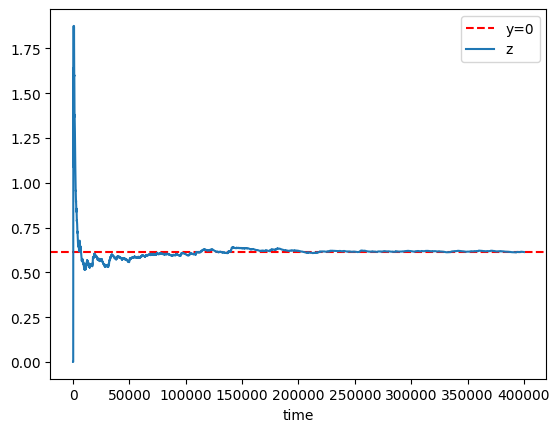

In [38]:
params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

def escaped(state: jf.State) -> float:
    return jp.sum(jp.linalg.norm(state.position, axis=-1) > config.sphere_radius)

key = jax.random.PRNGKey(0)
state = jf.init_state(config, key)
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
zs = stats.time_average_with_history(state, next_state, 400000, escaped)

plt.axhline(y=jp.mean(zs), color='r', linestyle='--', label=f'y=0')
plt.plot(zs, label='z')
plt.xlabel('time')
plt.legend()


### Bifurcation diagram

In [80]:
@functools.partial(jax.jit, static_argnames=['setter', 'config', 'n_steps', 'n_samples', 'J'])
def time_average_sweep(
        key: jax.Array,
        params: jf.Params, 
        setter: Callable[[jf.Params, float], jf.Params],
        range: jax.Array,
        config: jf.Config, 
        n_steps: int, 
        n_samples: int,
        J: Callable[[jf.State], float]):
        
    def sample(key, params):
        def step(i, acc):
            time_step = 1 / 60
            state, sum_J = acc
            next_state = jf.next_state(params, config, time_step, state)
            return next_state, J(next_state) + sum_J

        state = jf.init_state(config, key)
        sum_J = jax.lax.fori_loop(1, n_steps, step, (state, J(state)))[1]
        return sum_J / n_steps

    def collect(key, x):
        actual_params = setter(params, x)
        keys = jax.random.split(key, n_samples)
        samples = jax.vmap(sample, in_axes=(0, None))(keys, actual_params)
        return jp.mean(samples), jp.std(samples)

    keys = jax.random.split(key, range.shape[0])
    return jax.vmap(collect, in_axes=(0, 0))(keys, range)

params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 100,
    sphere_radius = 30.0
)
 
def average_separation(state: jf.State) -> float:
    positions = state.position
    n_agents = positions.shape[0]
    n_pairs = n_agents * (n_agents - 1) // 2
    return jp.sum(jp.linalg.norm(positions[:, None] - positions[None, :], axis=-1)) / n_pairs

# mean, std = time_average_sweep(
#     jax.random.PRNGKey(0),
#     params,
#     lambda params, x: params.replace(weight_separate=x),
#     range,
#     config,
#     200000,
#     100,
#     average_separation
# )

range = jp.linspace(0.5, 1.5, 30)
mean, std = time_average_sweep(
    jax.random.PRNGKey(0),
    params,
    lambda params, x: params.replace(weight_separate=x),
    range,
    config,
    250000,
    100,
    average_separation
)

expensive :( 30 params * 100 trials per param * 250k steps per trial took ~23 minutes

Text(0, 0.5, 'average_separation')

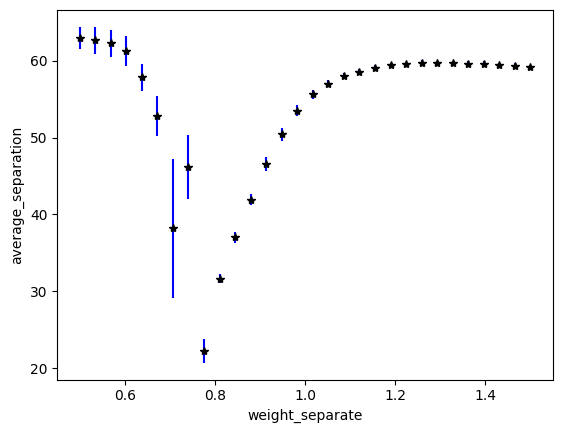

In [81]:
plt.errorbar(range, mean, yerr=std, fmt='k*', ecolor='b')

plt.xlabel('weight_separate')
plt.ylabel('average_separation')

### Phase diagram

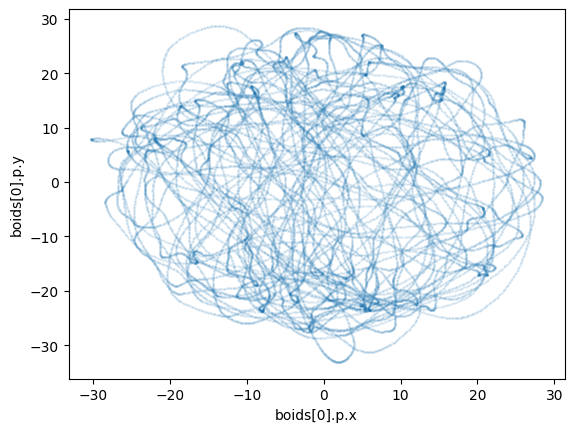

In [22]:
params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

state = jf.init_state(config, jax.random.PRNGKey(0))
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
pos = stats.trajectory(state, next_state, 30000, lambda state: state.position[0, :2])

plt.scatter(pos[:, 0], pos[:, 1], s=1, alpha=0.1)
plt.xlabel('boids[0].p.x')
plt.ylabel('boids[0].p.y')
plt.show()

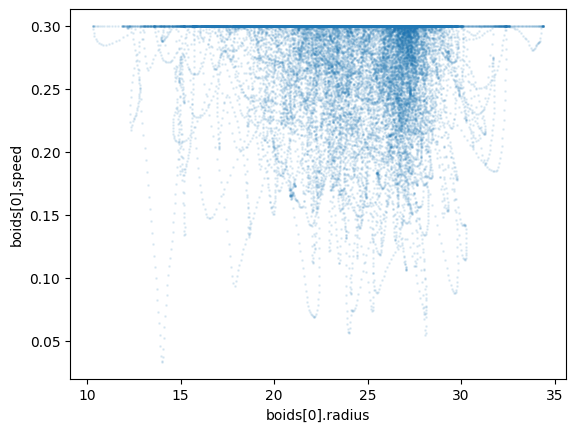

In [24]:
def get_pos(state: jf.State):
    dist = jp.linalg.norm(state.position[0], axis=-1)
    return jp.hstack([dist, state.speed[0]])
params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

state = jf.init_state(config, jax.random.PRNGKey(0))
def next_state(state):
    return jf.next_state(params, config, 1 / 60, state)
pos = stats.trajectory(state, next_state, 30000, get_pos)

plt.scatter(pos[:, 0], pos[:, 1], s=1, alpha=0.1)
plt.xlabel('boids[0].radius')
plt.ylabel('boids[0].speed')
plt.show()